# COVID-19 Spain Analysis & Forecast

For this forecast we used data of the registred Covid cases from 2020 March, 23th to 2020, April, 19th in Spain. The data was collected eahch day from oficial web of Ministry of Health of Goverment in Spain. [Source](https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/home.htm)

We will use SARIMAX model and Lineal Regression model for the forecast of Covid cases. Let's build both models and observe how it works with Time Series.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
from itertools import product
filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection, linear_model, metrics

Populating the interactive namespace from numpy and matplotlib


### Data load

In [2]:
#Number of sick persons per day from 2020-03-23
n_sick = [33928, 39673, 47610, 56188, 64059, 72248, 78797, 85195, 94417, 102036, 110238, 117710, 124736, 130759, 135032, \
          140510, 146690, 152446, 157022, 161852, 166019, 169496, 172541, 177633, 182816, 188068, 191726, 195944, 200210, \
          204178, 208389, 213024, 219764, 205905, 207634, 209465, 210773, 212917, 213435, 215216, 216582, 217466, 218011, \
          219329, 220325, 221447, 222857, 223578, 224390, 227436, 228030, 228691, 229540, 230183, 230698, 230929, 231350, \
          231606, 232555, 233037, 234824, 235290, 235772]
n = len(n_sick)
n

63

In [3]:
date_list = [datetime.datetime.strptime('2020-03-23', '%Y-%m-%d') + relativedelta(days=x) for x in range(0,n)]
data = pd.DataFrame(index=date_list, columns = ['Sick'], data = n_sick)
display(data.head())
print('...')
display(data.tail())

,Sick
2020-03-23,33928
2020-03-24,39673
2020-03-25,47610
2020-03-26,56188
2020-03-27,64059


...


,Sick
2020-05-20,232555
2020-05-21,233037
2020-05-22,234824
2020-05-23,235290
2020-05-24,235772


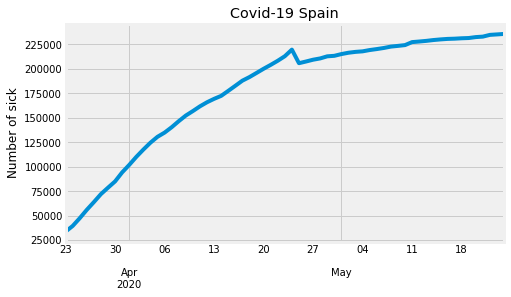

In [4]:
# Data Visualization
plt.figure(figsize(7,4))
data.Sick.plot()
pylab.title('Covid-19 Spain')
plt.ylabel('Number of sick')
pylab.show()

### Anomaly Detection

Although, the data is from official source, we can observe some anomaly between April 19th and 26th. We can not drop this data, so, let's replace it with interpolate values.

In [5]:
data0 = data.copy()
data0.loc['20200419':'20200426'] = np.nan
data0.interpolate('polynomial', order=2, inplace=True)

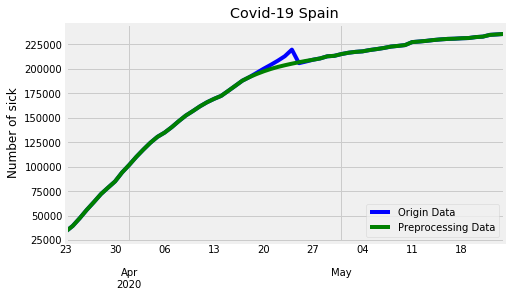

In [6]:
# Data Visualization after processing
plt.figure(figsize(7,4))
data.Sick.plot(color='b', label = 'Origin Data')
data0.Sick.plot(color='g', label = 'Preprocessing Data')
pylab.legend(loc='lower right')
pylab.title('Covid-19 Spain')
plt.ylabel('Number of sick')
pylab.show()

In [7]:
# Split data to 49 train samples and 14 test samples
data_train = data0.iloc[:49, :]
data_test = data0.iloc[49:, :]

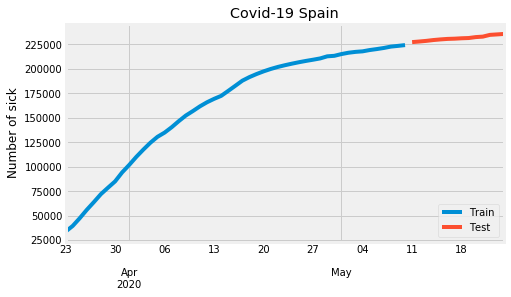

In [8]:
plt.figure(figsize(7,4))
data_train.Sick.plot(label = 'Train')
data_test.Sick.plot(label = 'Test')
pylab.title('Covid-19 Spain')
plt.ylabel('Number of sick')
pylab.legend(loc='lower right')
pylab.show()

# 1. SARIMAX
### Time Series model

### 1.1. Visualization & decomposition

DF-test: p=0.000008


<Figure size 720x576 with 0 Axes>

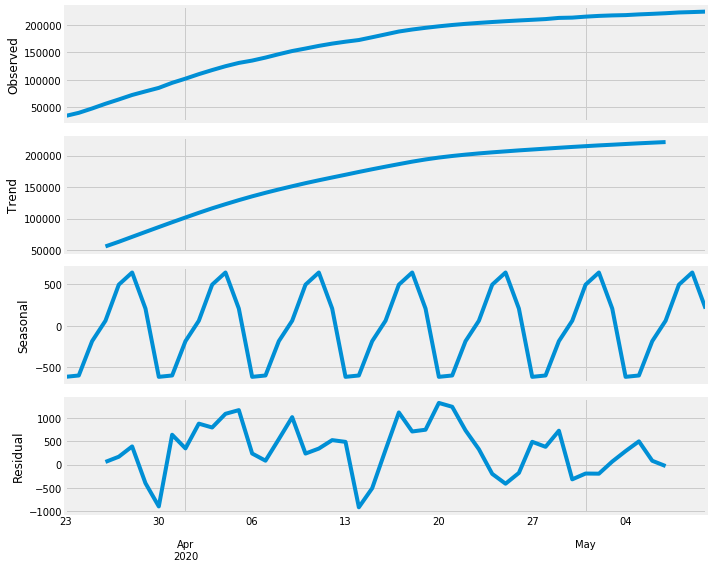

In [9]:
plt.figure(figsize(10,8))
sm.tsa.seasonal_decompose(data_train.Sick).plot()
print('DF-test: p=%f' % sm.tsa.stattools.adfuller(data_train.Sick)[1])

The trend is very clear and we can observe there is a week seasons in our data. Let's try season (1 week) differentiation and do stationarity test.

### 1.2. Differentiation

DF-test: p=0.226660


<Figure size 720x576 with 0 Axes>

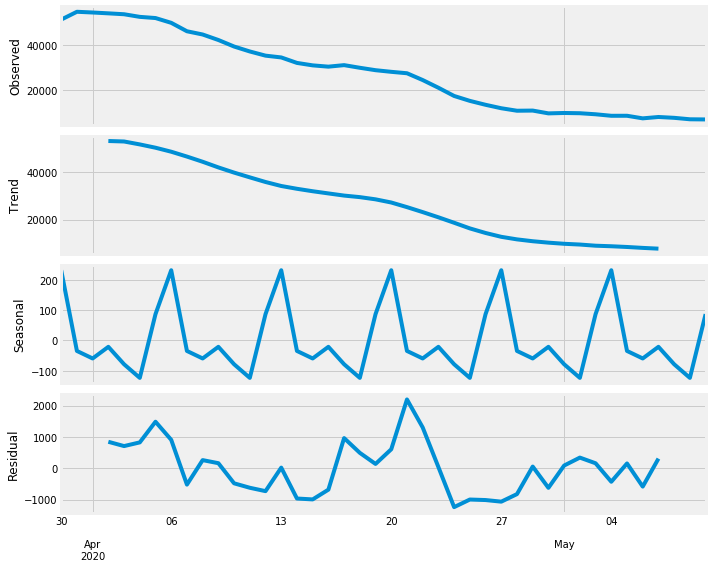

In [10]:
# First differentiaation
S1 = 7    # Lenght of period in days (lags):

data_train['Diff1'] = data_train['Sick'] - data_train['Sick'].shift(S1)   
plt.figure(figsize(10,8))
sm.tsa.seasonal_decompose(data_train.Diff1[S1:]).plot()
print('DF-test: p=%f' % sm.tsa.stattools.adfuller(data_train.Diff1[S1:])[1])

The Dickey-Fuller criterion does not reject the hypothesis of non-stationarity, and it was not possible to completely get rid of the trend. Let's try to add another usual differentiation:

DF-test: p=0.000056


<Figure size 720x576 with 0 Axes>

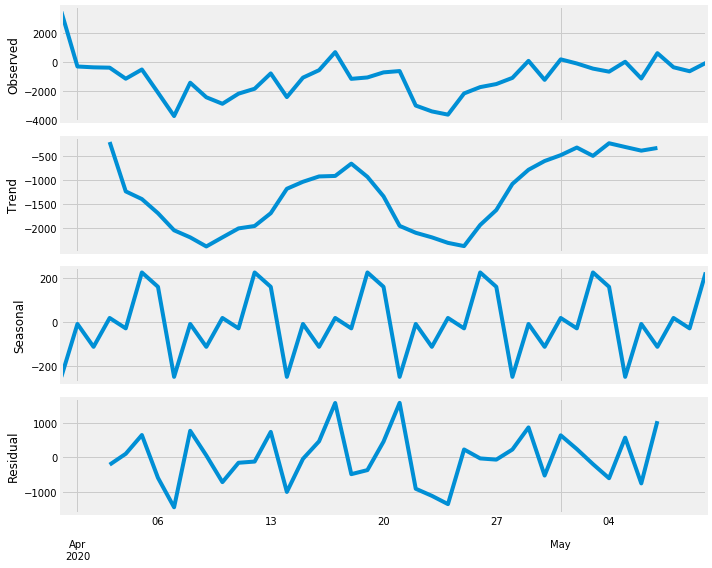

In [11]:
# Second differentiation
S2 = 1 # Lenght of period in days (lags):

data_train['Diff2'] = data_train['Diff1'][S1:] - data_train['Diff1'][S1:].shift(S2)  
plt.figure(figsize(10,8))
sm.tsa.seasonal_decompose(data_train.Diff2[(S1+S2):]).plot()
print('DF-test: p=%f' % sm.tsa.stattools.adfuller(data_train.Diff2[(S1+S2):])[1])

After one season and one simple differentiation the DF-test confirms stationarity of time series and there is no more trend there.

### 1.3. Initial approximations for p, q, P, Q

In [12]:
data1 = data_train.Diff2[(S1+S2):]
l = len(data1)
l

41

**ACF & PACF**

Let's observe Autocorrelation and Partial Correlation of series to define initial approximations of model parameters.

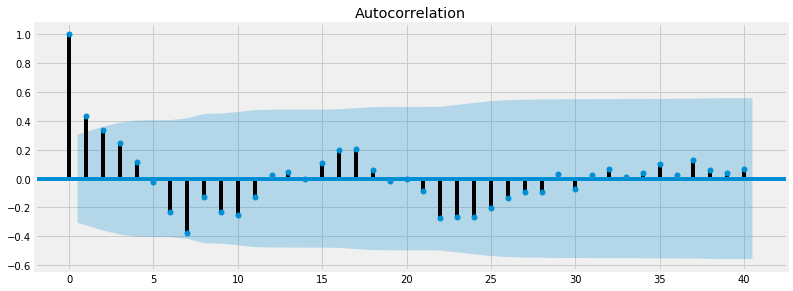

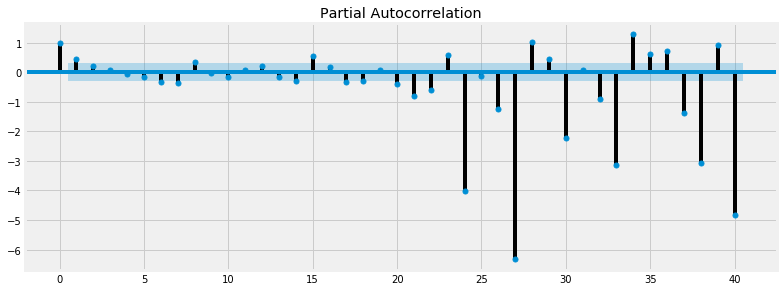

In [13]:
plt.figure(figsize(12,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data1.values.squeeze(), lags=l-1, ax=ax) 
#pylab.grid()
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data1.values.squeeze(), lags=l-1, ax=ax)
#pylab.grid()
pylab.show()

 The initial approximation of parameters will be: Q0 = 0, q0 = 1, P0 = 35/7 = 5, p0 = 6.

In [14]:
# Define parameters grid
p = range(0, 7)
q = range(0, 2)
P = range(0, 6)
Q = range(0, 1)
d = 1
D = 1
S = 7

parameters = list(product(p, q, P, Q))
len(parameters)

84

### 1.4. Model

In [15]:
%%time
results = []
best_aic = float('inf')
filterwarnings('ignore')

for param in parameters:
    try:                      
        model=sm.tsa.statespace.SARIMAX(data_train.Sick, order=(param[0], d, param[1]),
                                       seasonal_order=(param[2], D, param[3], S)).fit(disp=-1)      
    except LinAlgError:    # some of parameters can be invalid   
        print('wrong parameters:', param)
        continue
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 5, 0)
wrong parameters: (1, 0, 5, 0)
CPU times: user 1min 21s, sys: 5.46 s, total: 1min 26s
Wall time: 43.5 s


In [16]:
# Keep the best model using Aic criteria
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
28  (2, 1, 0, 0)  695.795969
40  (3, 1, 0, 0)  697.007233
46  (4, 0, 0, 0)  697.047269
29  (2, 1, 1, 0)  697.724698
58  (5, 0, 0, 0)  698.210222
                                 Statespace Model Results                                
Dep. Variable:                              Sick   No. Observations:                   49
Model:             SARIMAX(2, 1, 1)x(0, 1, 0, 7)   Log Likelihood                -343.898
Date:                           Sun, 12 Jul 2020   AIC                            695.796
Time:                                   12:14:51   BIC                            702.650
Sample:                               03-23-2020   HQIC                           698.292
                                    - 05-10-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

### 1.5. Residuals Analysis

T-Student criteria: p=0.536964
DF-test: p=0.000372


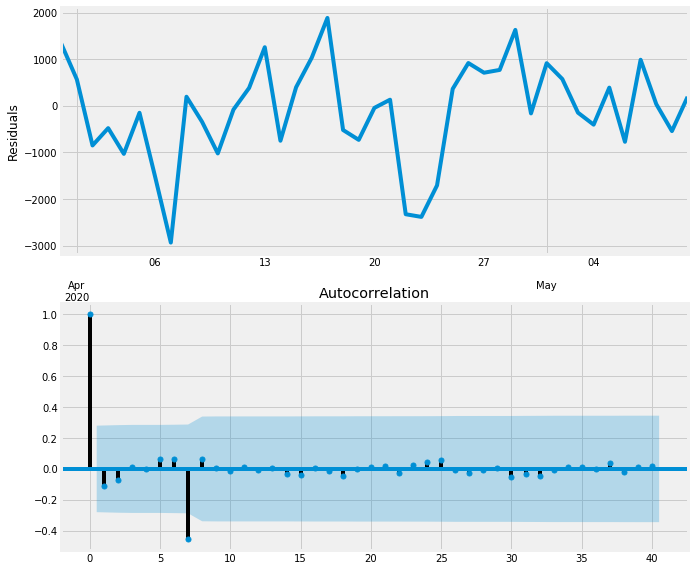

In [17]:
plt.figure(figsize(10,10))
plt.subplot(211)
best_model.resid[S1+S2:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=l-1, ax=ax)

print('T-Student criteria: p=%f' % stats.ttest_1samp(best_model.resid[S1+S2:], 0)[1])
print('DF-test: p=%f' % sm.tsa.stattools.adfuller(best_model.resid[S1+S2:])[1])

The residues are unbiased (confirmed by T-Student criteria), are stationary (confirmed by the DF-test and visually), also not autocorrelated (confirmed by the correlogram).

### 1.6. Forecast for 14 days

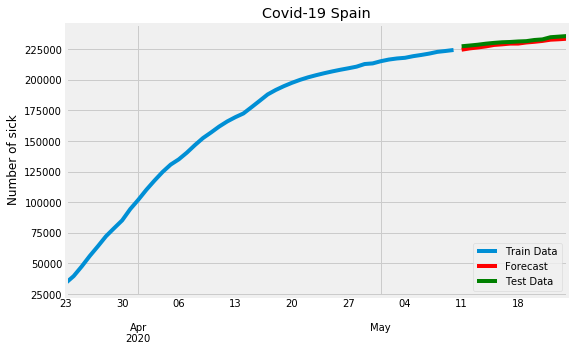

In [18]:
dataF = data_train[['Sick']]
N = 14        #Number of days for forecast:

#new start day
Start = data_train.tail(1).index[0] + pd.DateOffset(days=1)

date_list2 = [Start + relativedelta(days=x) for x in range(0,N)]
future = pd.DataFrame(index=date_list2, columns= dataF.columns)
dataF = pd.concat([dataF, future])
dataF['Forecast'] = best_model.predict(start=data_train.shape[0], end=data_train.shape[0]+N-1)

plt.figure(figsize(8,5))
dataF.Sick.plot(label = 'Train Data')
dataF.Forecast.plot(color='r', label = 'Forecast')
data_test.Sick.plot(color='g', label = 'Test Data')
pylab.title('Covid-19 Spain')
plt.ylabel('Number of sick')
pylab.legend(loc='lower right')
pylab.show()

In [19]:
dataF['Test'] = data_test
dataF['Forecast'] = round(dataF['Forecast'], 1)
dataF.tail(N)

,Sick,Forecast,Test
2020-05-11,NaN,224612.2,227436.0
2020-05-12,NaN,225692.0,228030.0
2020-05-13,NaN,226438.3,228691.0
2020-05-14,NaN,227326.1,229540.0
2020-05-15,NaN,228509.1,230183.0
2020-05-16,NaN,229012.2,230698.0
2020-05-17,NaN,229614.5,230929.0
2020-05-18,NaN,229635.0,231350.0
2020-05-19,NaN,230520.9,231606.0
2020-05-20,NaN,231080.6,232555.0


In [20]:
#Calculate mean abslolute error
mean_absolute_error(dataF['Test'].tail(N), dataF['Forecast'].tail(N))

1871.1999999999991

# 2. Linear Regression 

### 2.1. Data Transformation

As we could oberve week seasonality above, let's add the days of week to out data. Also we will transform the data to obtain more features using polynomial transformation of 2nd degree. (That is clear that trend is non linear.)

Our function will be:
$$ y = w0 + w1*X1 + w2*(X1)^2 + w3*X2$$
where:  
X1 - ordinal number of day,
X2 - day of week

In [21]:
data0['Weekday'] = data0.index.weekday
data0.head()

,Sick,Weekday
2020-03-23,33928.0,0
2020-03-24,39673.0,1
2020-03-25,47610.0,2
2020-03-26,56188.0,3
2020-03-27,64059.0,4


In [22]:
Y = data0['Sick'].to_numpy()
n = len(Y)
x1 = [i for i in range(1,n+1)]      # number of day (real values)
X2 = data0['Weekday'].to_numpy()    # day of week   (categorical values) 

In [23]:
poly_transform = PolynomialFeatures(2)
X1_poly = poly_transform.fit_transform(np.array([x1]).T)  

In [24]:
X1_train = X1_poly[:49, :]  #first 7 weeks
X1_test = X1_poly[49:, :]   #last 2 weeks

In [25]:
# Scaling
scaler = StandardScaler()     
scaler.fit(X1_train)
X1_train_scaled = scaler.transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

The day of week in our data is a categorical feature. In case of linear regression we could treate it as a real data, but it will be preciser to transform it to a binary data using OneHotEncoder for example.

In [26]:
# Binary transformation
enc = OneHotEncoder()
enc.fit(X2.reshape(-1,1))
X2_binary = enc.transform(X2.reshape(-1,1)).toarray()

In [27]:
X_train = np.hstack((X1_train_scaled, X2_binary[:49, :]))
X_test = np.hstack((X1_test_scaled, X2_binary[49:, :]))
Y_train = Y[:49]
Y_test = Y[49:]

### 2.2. Linear Regression with default parameters

In [28]:
%%time
LR = linear_model.LinearRegression()
LR.fit(X_train, Y_train)   
print('weights:')
for w in LR.coef_:
    print(round(w,3))
print(f'intercept:  {round(LR.intercept_,3)}') 

weights:
0.0
123977.77
-71547.774
-642.051
-918.721
-497.399
-11.605
505.831
833.675
730.27
intercept:  162531.382
CPU times: user 2.12 ms, sys: 503 µs, total: 2.62 ms
Wall time: 2.44 ms


In [29]:
Y_fit = LR.predict(X_train)
Y_pred = LR.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

26561.269512614217

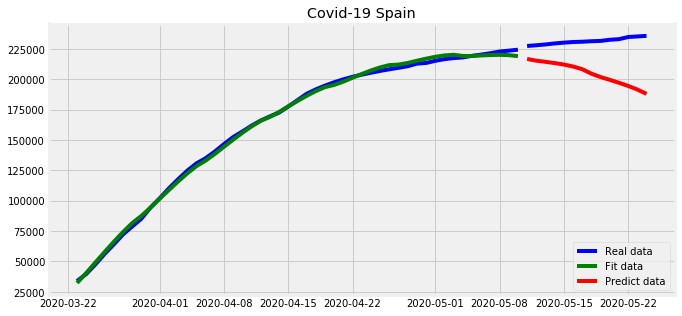

In [30]:
plt.figure(figsize(10,5))
#pylab.grid(True)
pylab.plot(date_list[:49], Y_train, 'b-', label='Real data')
pylab.plot(date_list[:49], Y_fit, 'g-', label='Fit data')

pylab.plot(date_list[49:], Y_test, 'b-')
pylab.plot(date_list[49:], Y_pred, 'r-', label='Predict data')
pylab.legend(loc='lower right')
pylab.title('Covid-19 Spain')
pylab.show()

Let's try L2 regularization to avoid overfitting in our Linear Regression model.

### 2.2. Linear Regression with L2-regularization

In [31]:
# Parameters grid
alpha_param = [0.05, 0.1, 0.5, 1, 5, 10 ,50]

In [32]:
%%time
for a in alpha_param:
    LR = linear_model.Ridge(alpha = a)
    LR.fit(X_train, Y_train)      # learning
    Y_pred = LR.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    print(f'alpha: {a},  mean absolute error: {round(mae,3)}')

alpha: 0.05,  mean absolute error: 23346.065
alpha: 0.1,  mean absolute error: 20337.14
alpha: 0.5,  mean absolute error: 3065.842
alpha: 1,  mean absolute error: 12700.083
alpha: 5,  mean absolute error: 44613.049
alpha: 10,  mean absolute error: 48391.005
alpha: 50,  mean absolute error: 23096.09
CPU times: user 10.9 ms, sys: 2.85 ms, total: 13.7 ms
Wall time: 14.5 ms


In [33]:
# optimal alpha 0.5
LR = linear_model.Ridge(alpha = 0.5)
LR.fit(X_train, Y_train)
print('weights:')
for w in LR.coef_:
    print(round(w,3))
print(f'intercept:  {round(LR.intercept_,3)}') 

weights:
0.0
99319.753
-47173.027
-958.507
-993.007
-438.431
113.935
633.45
913.631
728.929
intercept:  162531.382


In [34]:
Y_fit = LR.predict(X_train)
Y_pred = LR.predict(X_test)

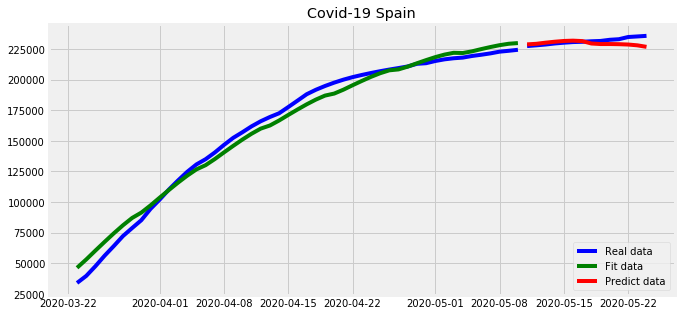

In [35]:
plt.figure(figsize(10,5))
#pylab.grid(True)
pylab.plot(date_list[:49], Y_train, 'b-', label='Real data')
pylab.plot(date_list[:49], Y_fit, 'g-', label='Fit data')

pylab.plot(date_list[49:], Y_test, 'b-')
pylab.plot(date_list[49:], Y_pred, 'r-', label='Predict data')
pylab.legend(loc='lower right')
pylab.title('Covid-19 Spain')
pylab.show()

### Conclusions

When working with the time series data type, we can use both the SARIMAX model and the Linear Regression model. In our example, L2-regularization within LinearRegression helped reduce the overfit, but is still unable to remove it entirely, while the SARIMAX model gets the best result. However, it is more difficult to adjust it and needs more time to process.